In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import os

from scipy.stats import spearmanr as rho
import warnings

warnings.filterwarnings('ignore')

In [4]:
folder_ = os.path.join(os.getcwd(), "data")
no_frost_test = np.load(os.path.join(folder_, "no_frost_test.npy"))
frost_test = np.load(os.path.join(folder_, "frost_test.npy"))

In [5]:
method_names = ["IG", "DL", "LRP", "Ens"]

# Random v Medoid Neighbourhood generation

In [6]:
folder_r = os.path.join(os.getcwd(), "results_random") # IG, DL, LRP con intorno random
rho_test_r = np.load(os.path.join(folder_r, "Test", "robustness.npy"))

In [7]:
rob_test = np.load(os.path.join(os.getcwd(), "results", "Test", "robustness_ensemble.npy"))

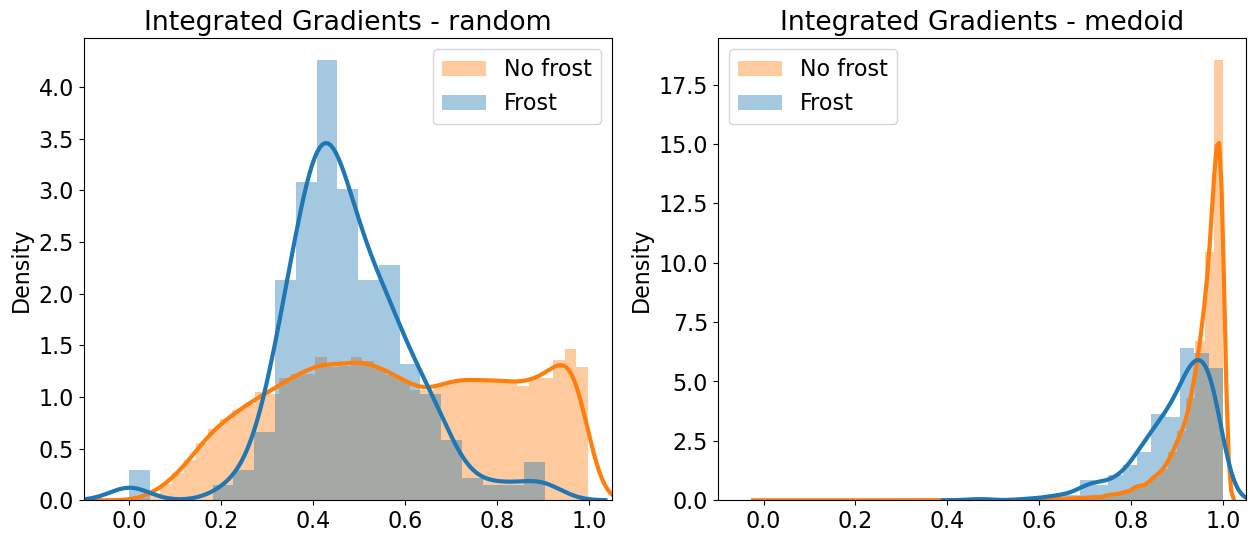

In [10]:
fig, ax = plt.subplots(1,2, figsize= (15,6))
plt.rcParams["font.size"] = 16
lwd = 3

sns.distplot(rho_test_r[no_frost_test,0], ax = ax[0], label="No frost", color="tab:orange", kde_kws=dict(linewidth=lwd))
sns.distplot(rho_test_r[frost_test,0], ax = ax[0], label="Frost", color = "tab:blue", kde_kws=dict(linewidth=lwd))

sns.distplot(rob_test[no_frost_test,0], ax = ax[1], label="No frost", color="tab:orange", kde_kws=dict(linewidth=lwd))
sns.distplot(rob_test[frost_test,0], ax = ax[1], label="Frost", color="tab:blue",kde_kws=dict(linewidth=lwd))

for ax_ in (ax[0], ax[1]):
    ax_.legend()
    ax_.set_xlim(-0.1, 1.05)

ax[0].set_title("Integrated Gradients - random")
ax[1].set_title("Integrated Gradients - medoid")

plt.show()

# Weighted average + consistency score

In [11]:
folder_=os.path.join(os.getcwd(), "results")

In [12]:
rho_test_m = np.load(os.path.join(folder_, "Test", "robustness.npy"))

In [13]:
rho_test_ens = np.load(os.path.join(folder_, "Test", "robustness_ensemble.npy"))

In [14]:
attr = np.load(os.path.join(folder_, "Test", "attributions.npy"))
neigh_test = np.load(os.path.join(folder_, "Test", "neigh_size.npy"))
distances_test = np.load(os.path.join(folder_, "Test", "distances.npy"))
ensemble = np.load(os.path.join(folder_, "Test", "ensemble.npy"))

In [15]:
print(attr.shape, neigh_test.shape, distances_test.shape, ensemble.shape)

(29966, 101, 8, 3) (29966,) (29966, 100) (29966, 101, 8)


In [16]:
distance = np.copy(distances_test)

In [17]:
for el in range(attr.shape[0]):
    distance[el,:(neigh_test[el]-1)] = 1.0/distances_test[el, :(neigh_test[el]-1)]

In [18]:
np.sum(distance, axis=1).shape

(29966,)

In [19]:
w_avg = np.sum(np.multiply(attr[:, 1:, :, :], distance[:,:,np.newaxis, np.newaxis]), axis=1)/np.sum(distance, axis=1)[:, np.newaxis, np.newaxis] #Per IG, DL, LRP
print(w_avg.shape)
w_ens = np.sum(np.multiply(ensemble[:,1:,:], distance[:,:, np.newaxis]), axis=1)/np.sum(distance, axis=1)[:, np.newaxis] # per ensemble
print(w_ens.shape)

(29966, 8, 3)
(29966, 8)


In [20]:
RHO = np.zeros((w_avg.shape[0], w_avg.shape[2]+1)) 

# attr ha dimensione (numero di punto x (numero di perturbazioni +1) x numero features x numero metodi)
# Nella seconda dimensione, il vettore in posizione 0 rappresenta le attribuzioni del punto originale, quelli successivi sono le perturbazioni invece


for m in range(3):
    for i in range(RHO.shape[0]):
        RHO[i, m] = rho(attr[i, 0, :, m], w_avg[i,:,m]).statistic   

for i in range(RHO.shape[0]):
    RHO[i,3] = rho(ensemble[i, 0, :], w_ens[i, :]).statistic

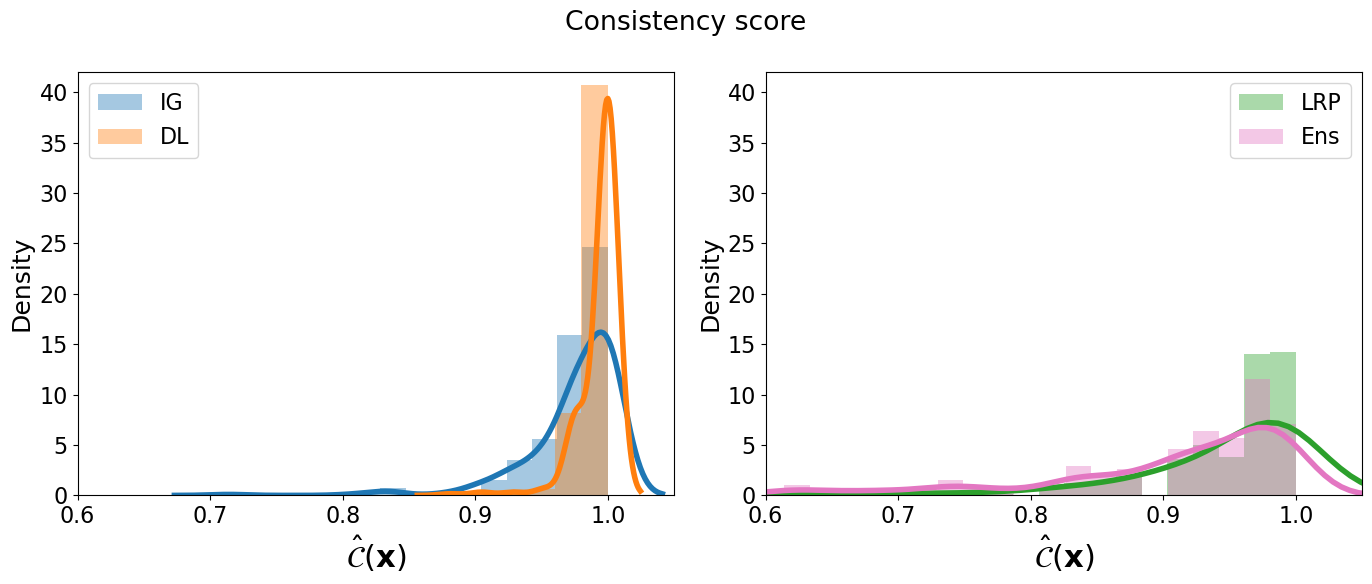

In [21]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:pink']
plt.rcParams["font.size"] = 16


sns.distplot(RHO[frost_test,0], ax = ax[0], label=method_names[0], color = colors[0] ,kde_kws=dict(linewidth=4, bw_adjust=1.2), bins=15)
sns.distplot(RHO[frost_test,1], ax = ax[0], label=method_names[1], color = colors[1] ,kde_kws=dict(linewidth=4, bw_adjust=1.7), bins=6)
sns.distplot(RHO[frost_test,2], ax=ax[1], label = method_names[2], color = colors[2], kde_kws=dict(linewidth=4, bw_adjust=0.5), bins=70)
sns.distplot(RHO[frost_test,3], ax=ax[1], label = method_names[3], color = colors[3], kde_kws=dict(linewidth=4, bw_adjust=0.5), bins=58)


ax[0].set_xlim(0.6,1.05)
ax[0].set_xticks([0.60, 0.70,0.80,0.90,1.00])
ax[1].set_xlim(0.6,1.05)

ax[0].set_ylim(0, 42)

ax[1].set_ylim(0, 42)
# sns.distplot(rho_test_ens[frost_test,3], label="Old")
# plt.legend()
# plt.title("Frost only - Ensemble")
ax[0].legend(loc='upper left')
ax[1].legend()

ax[0].set_xlabel("$\hat{\mathcal{C}}(\mathbf{x})$", fontsize=22)
ax[1].set_xlabel("$\hat{\mathcal{C}}(\mathbf{x})$", fontsize=22)
ax[0].set_ylabel("Density",fontsize=18)
ax[1].set_ylabel("Density",fontsize=18)

plt.suptitle("Consistency score")
plt.tight_layout()
plt.show()

# Ensemble robustness

In [22]:
rob_test = np.load(os.path.join(os.getcwd(), "results", "Test", "robustness_ensemble.npy"))

In [23]:
print(np.round(100*np.nanmean(rob_test[frost_test], axis=0), 2))
print(np.round(100*np.nanstd(rob_test[frost_test], axis=0),2))

[89.34 97.69 76.77 79.03]
[ 8.35  2.26 15.7  12.56]


In [24]:
print(np.round(100*np.nanmean(RHO[frost_test], axis=0),2))
print(np.round(100*np.nanstd(RHO[frost_test], axis=0),2))

[97.56 99.4  89.86 89.2 ]
[ 3.58  1.51 19.95 13.73]


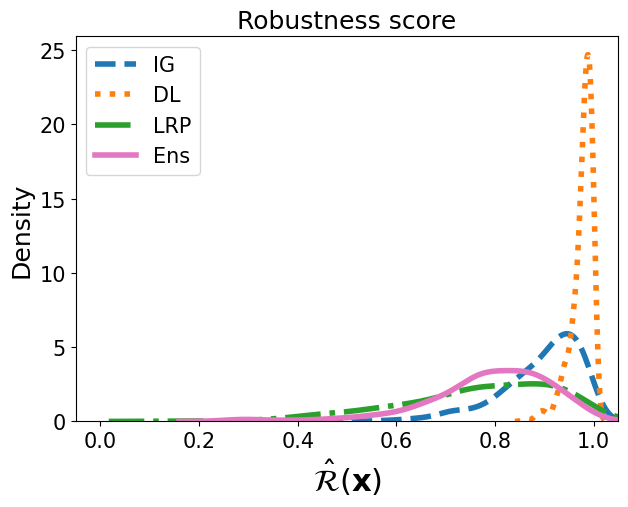

In [25]:
plt.figure(figsize=(7,5))
plt.rcParams["font.size"] = 15
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:pink']
linetype = ['--', ':', '-.', '-']
for i in range(4):
    sns.distplot(rob_test[frost_test,i], label=method_names[i], hist=False, kde_kws=dict(linewidth=4, linestyle=linetype[i]), color=colors[i])
    
plt.legend()
plt.xlabel("$\hat{\mathcal{R}}(\mathbf{x})$", fontsize=22)
plt.ylabel("Density",fontsize=18)
plt.xlim(-0.05,1.05)
plt.title("Robustness score")
plt.show()